In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/istanbul-municipality-traffic-density-data-2024aug/traffic_density__202408.csv


# Import data

In [2]:
df_= pd.read_csv("/kaggle/input/istanbul-municipality-traffic-density-data-2024aug/traffic_density__202408.csv")

# Basics

In [3]:
df_.head()

,DATE_TIME,LONGITUDE,LATITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2024-08-01 00:00:00,28.427124,41.058655,sxk1wf,61,126,90,50
1,2024-08-01 00:00:00,28.591919,41.102600,sxk3fd,33,154,89,58
2,2024-08-01 00:00:00,28.339233,41.097107,sxk1uc,65,141,95,38
3,2024-08-01 00:00:00,28.229370,41.130066,sxk1fr,51,129,84,38
4,2024-08-01 00:00:00,28.493042,41.119080,sxk3bm,30,113,67,23


In [4]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720457 entries, 0 to 1720456
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   DATE_TIME           object 
 1   LONGITUDE           float64
 2   LATITUDE            float64
 3   GEOHASH             object 
 4   MINIMUM_SPEED       int64  
 5   MAXIMUM_SPEED       int64  
 6   AVERAGE_SPEED       int64  
 7   NUMBER_OF_VEHICLES  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 105.0+ MB


In [5]:
print(df_.describe())

          LONGITUDE      LATITUDE  MINIMUM_SPEED  MAXIMUM_SPEED  \
count  1.720457e+06  1.720457e+06   1.720457e+06   1.720457e+06   
mean   2.888709e+01  4.106318e+01   2.271245e+01   1.025793e+02   
std    3.570977e-01  1.009759e-01   2.414822e+01   3.719104e+01   
min    2.796570e+01  4.076752e+01   0.000000e+00   1.000000e+00   
25%    2.869080e+01  4.099823e+01   3.000000e+00   7.200000e+01   
50%    2.893250e+01  4.105865e+01   1.000000e+01   1.020000e+02   
75%    2.915222e+01  4.113007e+01   4.200000e+01   1.310000e+02   
max    2.963562e+01  4.134430e+01   1.950000e+02   2.550000e+02   

       AVERAGE_SPEED  NUMBER_OF_VEHICLES  
count   1.720457e+06        1.720457e+06  
mean    5.700636e+01        1.041731e+02  
std     2.571371e+01        1.296706e+02  
min     1.000000e+00        1.000000e+00  
25%     3.400000e+01        2.100000e+01  
50%     5.500000e+01        5.800000e+01  
75%     8.000000e+01        1.340000e+02  
max     1.950000e+02        1.549000e+03  


In [6]:
df_.isnull().sum()

DATE_TIME             0
LONGITUDE             0
LATITUDE              0
GEOHASH               0
MINIMUM_SPEED         0
MAXIMUM_SPEED         0
AVERAGE_SPEED         0
NUMBER_OF_VEHICLES    0
dtype: int64

# Traffic Density Over Time 

In [7]:
df_["DATE_TIME"] = pd.to_datetime(df_["DATE_TIME"])
df_["DATE"] = df_["DATE_TIME"].dt.date
df_["HOUR"] = df_["DATE_TIME"].dt.hour

In [8]:
traffic_density = df_.groupby(["DATE", "HOUR"])["NUMBER_OF_VEHICLES"].sum().reset_index()
traffic_density.head()

,DATE,HOUR,NUMBER_OF_VEHICLES
0,2024-08-01,0,171103
1,2024-08-01,1,113411
2,2024-08-01,2,82147
3,2024-08-01,3,68954
4,2024-08-01,4,81002


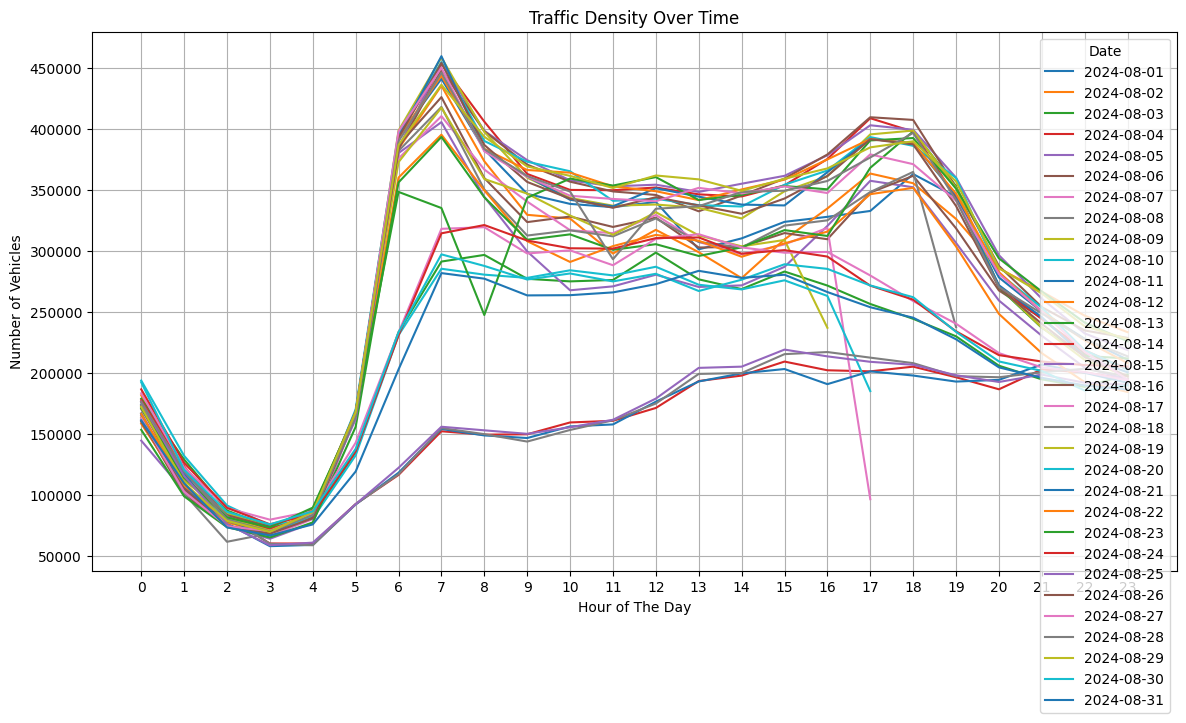

In [9]:
plt.figure(figsize=(14, 7))
for date in traffic_density["DATE"].unique():
    daily_data = traffic_density[traffic_density["DATE"] == date]
    plt.plot(daily_data["HOUR"], daily_data["NUMBER_OF_VEHICLES"], label=date)
    
plt.title("Traffic Density Over Time")
plt.xlabel("Hour of The Day")
plt.ylabel("Number of Vehicles")
plt.xticks(range(0, 24))
plt.legend(title="Date")
plt.grid()
plt.show()

# Speed Analysis

In [10]:
speed_analysis = df_.groupby('HOUR').agg({
    'MINIMUM_SPEED': 'mean',
    'MAXIMUM_SPEED': 'mean',
    'AVERAGE_SPEED': 'mean'
}).reset_index()

In [11]:
fig = px.line(speed_analysis, 
              x='HOUR', 
              y=['MINIMUM_SPEED', 'MAXIMUM_SPEED', 'AVERAGE_SPEED'],
              labels={'value': 'Speed (km/h)', 'HOUR': 'Hour of the Day'},
              title='Interactive Speed Analysis Throughout the Day',
              markers=True)
fig.update_layout(
    legend_title_text='Speed Types',
    xaxis=dict(tickmode='linear', tick0=0, dtick=1),
    yaxis_title='Speed (km/h)',
)

fig.show()

# Geospatial Visualization

In [12]:
traffic_density_map = df_.groupby(['LONGITUDE', 'LATITUDE']).agg({
    'NUMBER_OF_VEHICLES': 'sum'
}).reset_index()

In [13]:
fig = px.scatter_mapbox(
    traffic_density_map, 
    lon='LONGITUDE', 
    lat='LATITUDE', 
    size='NUMBER_OF_VEHICLES', 
    color='NUMBER_OF_VEHICLES',
    hover_name='NUMBER_OF_VEHICLES',
    mapbox_style="carto-positron",
    title='Traffic Density in Istanbul',
    size_max=20,
    zoom=10
)
fig.show()

# Speed vs. Vehicle Count

In [14]:
speed_vs_vehicles = df_.groupby('NUMBER_OF_VEHICLES').agg({
    'MINIMUM_SPEED': 'mean',
    'MAXIMUM_SPEED': 'mean',
    'AVERAGE_SPEED': 'mean'
}).reset_index()

fig = px.scatter(
    speed_vs_vehicles,
    x='NUMBER_OF_VEHICLES',
    y='AVERAGE_SPEED',
    size='MAXIMUM_SPEED',  
    color='MINIMUM_SPEED',  
    hover_name='NUMBER_OF_VEHICLES',
    title='Speed vs. Vehicle Count',
    labels={'AVERAGE_SPEED': 'Average Speed (km/h)', 'NUMBER_OF_VEHICLES': 'Number of Vehicles'},
    size_max=20
)
fig.update_layout(
    xaxis_title='Number of Vehicles',
    yaxis_title='Average Speed (km/h)',
    legend_title_text='Minimum Speed (km/h)',
)

fig.show()

# Peak Traffic Times

In [15]:
peak_traffic_times = df_.groupby('HOUR').agg({'NUMBER_OF_VEHICLES': 'sum'}).reset_index()

In [16]:
fig = px.bar(
    peak_traffic_times, 
    x='HOUR', 
    y='NUMBER_OF_VEHICLES',
    title='Peak Traffic Times in Istanbul',
    labels={'NUMBER_OF_VEHICLES': 'Total Number of Vehicles', 'HOUR': 'Hour of the Day'},
)

fig.update_layout(
    xaxis=dict(tickmode='linear', tick0=0, dtick=1), 
    yaxis_title='Total Number of Vehicles',
    xaxis_title='Hour of the Day',
)

fig.show()

# Predicting Traffic Density

* I need to take a sample to make LSTM fast.

In [17]:
sample_percentage = 0.1  #10% of the data
df = df_.sample(frac=sample_percentage, random_state=42)

df.reset_index(drop=True, inplace=True)

print("Sampled Data Shape:", df.shape)

Sampled Data Shape: (172046, 10)


## Feature Engineering

In [18]:
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

In [19]:
df['HOUR'] = df['DATE_TIME'].dt.hour
df['DAY'] = df['DATE_TIME'].dt.dayofweek  #Monday=0, Sunday=6
df['WEEKEND'] = (df['DAY'] >= 5).astype(int)

In [20]:
X = df[['HOUR', 'DAY', 'WEEKEND', 'MINIMUM_SPEED', 'MAXIMUM_SPEED', 'AVERAGE_SPEED']]
y = df['NUMBER_OF_VEHICLES']#target

## Scaling 

In [21]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

## Function for Create Sequences

In [22]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [23]:
time_steps = 10  #you can adjust this value if you want
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

## Split Data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

## Build LSTM Model

In [25]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  #for prevent overfitting
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping and Model Checkpoint Callbacks

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

## Compiling Model

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error')

## Training Model

In [28]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 2/50
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 3/50
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 4/50
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 5/50
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 6/50
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 7/50
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 8/50
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 9/50
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 0.0081 - val_loss: 0.0081


## Make Prediction

In [29]:
y_pred_scaled = model.predict(X_test)


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


In [30]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

## Evaluate the model

In [31]:
mse_lstm = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error (LSTM): {mse_lstm}')

Mean Squared Error (LSTM): 16695.044326300336


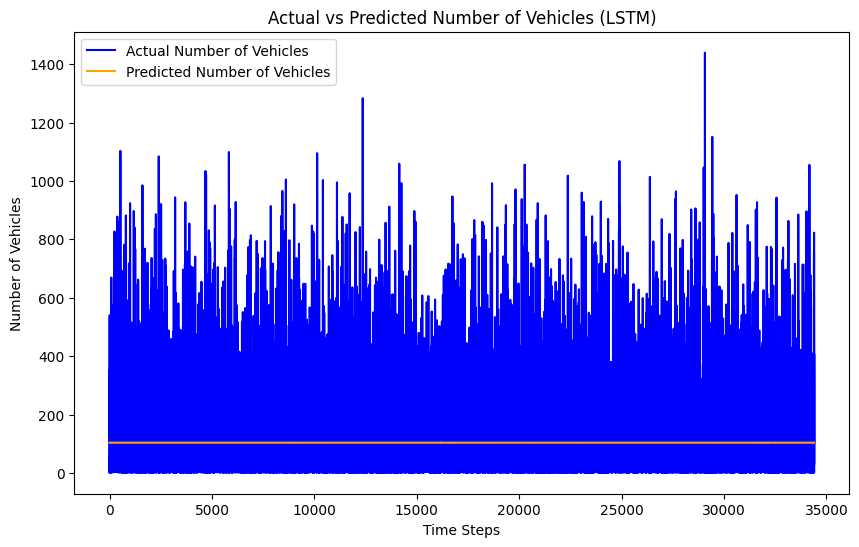

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Number of Vehicles', color='blue')
plt.plot(y_pred, label='Predicted Number of Vehicles', color='orange')
plt.title('Actual vs Predicted Number of Vehicles (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [33]:
mae_lstm = mean_absolute_error(y_test_actual, y_pred)
print(f'Mean Absolute Error (MAE): {mae_lstm}')

rmse_lstm = np.sqrt(mse_lstm)
print(f'Root Mean Squared Error (RMSE): {rmse_lstm}')

r2_lstm = r2_score(y_test_actual, y_pred)
print(f'R-squared (R²): {r2_lstm}')

Mean Absolute Error (MAE): 88.88560666884968
Root Mean Squared Error (RMSE): 129.20930433331935
R-squared (R²): -4.567643866693061e-06


In [34]:
#and i do not know what to say :( 